This Notebook exemplifies using the learned primal-dual reconstruction method on the LoDoPaB-CT dataset

# Imports

In [1]:
import astra
import odl
import numpy as np
import dival
from dival import get_standard_dataset
import torch
import torch.nn as nn
from primaldual import LearnedPrimalDual
from matplotlib import pyplot as plt

# Parameters
(not necessarily good settings)

In [2]:
BATCH_SIZE = 1
LEARNING_RATE = 1e-4
NUM_EPOCHS = 10

# Should be set to False later
ONLY_DO_ONE_TRAINING_STEP = True

# Helper functions

In [3]:
def to_np(tensor):
    return tensor.cpu().detach().numpy()

def show_img(tensor, title=None):
    plt.figure()
    plt.imshow(to_np(tensor), cmap='Greys_r')
    plt.title(title)
    plt.show()

# Setting up ODL operators
from the DIVαℓ source code

In [4]:
# linear attenuations in m^-1
MU_WATER = 20
MU_AIR = 0.02
MU_MAX = 3071 * (MU_WATER - MU_AIR) / 1000 + MU_WATER

# ~26cm x 26cm images
MIN_PT = [-0.13, -0.13]
MAX_PT = [0.13, 0.13]

NUM_ANGLES = 1000
RECO_IM_SHAPE = (362, 362)

# image shape for simulation
IM_SHAPE = (1000, 1000)  # images will be scaled up from (362, 362)
IM_SHAPE = RECO_IM_SHAPE

reco_space = odl.uniform_discr(min_pt=MIN_PT, max_pt=MAX_PT,
                               shape=RECO_IM_SHAPE, dtype=np.float32)
space = odl.uniform_discr(min_pt=MIN_PT, max_pt=MAX_PT, shape=IM_SHAPE,
                          dtype=np.float32)

reco_geometry = odl.tomo.parallel_beam_geometry(
    reco_space, num_angles=NUM_ANGLES)
geometry = odl.tomo.parallel_beam_geometry(
    space, num_angles=NUM_ANGLES, det_shape=reco_geometry.detector.shape)

IMPL = 'astra_cuda'
reco_ray_trafo = odl.tomo.RayTransform(reco_space, reco_geometry, impl=IMPL)
ray_trafo = odl.tomo.RayTransform(space, geometry, impl=IMPL)

# Create LoDoPaB-CT Datasets

In [5]:
dataset = get_standard_dataset('lodopab')

Training data loader

In [6]:
torch_dataset = dataset.create_torch_dataset('train')
data_loader = torch.utils.data.DataLoader(torch_dataset, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)

Validation data loader

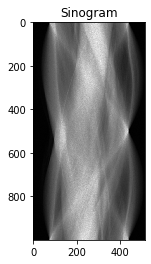

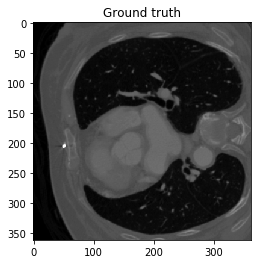

In [7]:
validation_dataset = dataset.create_torch_dataset('validation')
validation_data_loader = torch.utils.data.DataLoader(torch_dataset, 
                                                     batch_size=BATCH_SIZE, 
                                                     shuffle=False)
show_img(validation_dataset[0][0], 'Sinogram')
show_img(validation_dataset[0][1], 'Ground truth')

# Comparison baseline: Filtered Backprojection

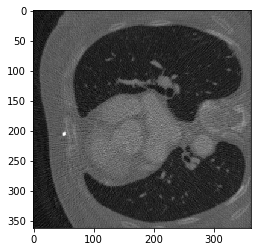

In [8]:
fbp = odl.tomo.fbp_op(ray_trafo, filter_type='Ram-Lak', frequency_scaling=0.8)
fbp_reconstruction = fbp(to_np(validation_dataset[0][0]))
plt.imshow(fbp_reconstruction, cmap='Greys_r')

# Set up neural net

In [9]:
model = LearnedPrimalDual(ray_trafo).to('cuda:0')

# Create training loop

In [10]:
loss_curve = []
epoch = 0
optimizer = torch.optim.Adam(
    list(model.parameters()),
    lr=LEARNING_RATE)

In [11]:
num_epochs = NUM_EPOCHS
while epoch < num_epochs:
    for batch_id, sample in enumerate(data_loader):
        sinogram, ground_truth = sample
        
        # add channel dimensions
        sinogram = torch.unsqueeze(sinogram, 1).to('cuda:0') 
        ground_truth = torch.unsqueeze(ground_truth, 1).to('cuda:0')
        
        model.zero_grad()
        output = model(sinogram)
        loss = nn.functional.mse_loss(output, ground_truth)
        loss.backward()
        optimizer.step()
        
        if ONLY_DO_ONE_TRAINING_STEP:
            break
        
    epoch += 1
    if ONLY_DO_ONE_TRAINING_STEP:
        print("Okey dokey!")
        break

Okey dokey!
